# Data Cleaning Project 1

## Part I - Predicting price group for fruit products

The data for this project comes from a The United States Department of Agriculture (USDA)  [USDA ERS- Fruit and Vegetable Prices](https://www.ers.usda.gov/data-products/fruit-and-vegetable-prices/) (Economics Research Service). ERS estimated the average prices for 156 commonly consumed fresh and processed fruits and vegetables. For this project, we'll only use the fruit files. 

The following variables are provided in the datasets:

* **Form** : Description of fruit
* **Average retail price and unit** : Average retail price and its unit in America
* **Preparation yield factor** : indicator of element type
* **Size and unit of a cup equivalent** : Amount of fruit that's equivalent to one cup 
* **Average price per cup equivalent**: cost of 1 cup of fruit in dollars

For this project, we will: 

1. Read the documentation and familiarize yourself with the dataset. 
2. Combine all of the data files into one large dataset with meaningful variables. 
3. Find the two fruit products that are the least and most expensive across all fruits.
4. Find the fruits that are the least and most expensive for each fruit type.
5. Make a bar chart of average price per cup of all fruit, colored by fruit type.
6. Make a sorted bar chart for a better visualization. 
7. Determine the fruit with highest investment value by comparing average price per cup and preparation ratio. 
8. Find the difference between the highest and lowest type of fruit among each fruit. 
9. Apply several machine learning algorithm to predict the price group (price as a categorical variable) by using other variables. 


### Data Cleaning

In [3]:
# load necessary packages 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# change display format
pd.options.display.float_format = '{:.2f}'.format

listOfFiles = glob.glob("data/Part I/*.xlsx")
listOfFiles

['data/Part I\\apples.xlsx',
 'data/Part I\\apricots.xlsx',
 'data/Part I\\bananas.xlsx',
 'data/Part I\\berries_mixed.xlsx',
 'data/Part I\\blackberries.xlsx',
 'data/Part I\\blueberries.xlsx',
 'data/Part I\\cantaloupe.xlsx',
 'data/Part I\\cherries.xlsx',
 'data/Part I\\cranberries.xlsx',
 'data/Part I\\dates.xlsx',
 'data/Part I\\figs.xlsx',
 'data/Part I\\fruit_cocktail.xlsx',
 'data/Part I\\grapefruit.xlsx',
 'data/Part I\\grapes.xlsx',
 'data/Part I\\honeydew.xlsx',
 'data/Part I\\kiwi.xlsx',
 'data/Part I\\mangoes.xlsx',
 'data/Part I\\nectarines.xlsx',
 'data/Part I\\oranges.xlsx',
 'data/Part I\\papaya.xlsx',
 'data/Part I\\peaches.xlsx',
 'data/Part I\\pears.xlsx',
 'data/Part I\\pineapple.xlsx',
 'data/Part I\\plums.xlsx',
 'data/Part I\\pomegranate.xlsx',
 'data/Part I\\raspberries.xlsx',
 'data/Part I\\strawberries.xlsx',
 'data/Part I\\tangerines.xlsx',
 'data/Part I\\watermelon.xlsx']

Combine multiple fruit files in a dataset after cleaning each dataset individually. In the process, unnecessary columns and rows were removed. The list of variables in the final dataset are: 
* **Fruit**: name of the fruit (derived from Form variable)
* **Type**: fresh, canned, or juice (derived from Form variable) 
* **Form**: description of fruit
* **Price**: price of fruit
* **Unit**: unit for price of fruit
* **Preparation yield factor**: Edible weight over total fruit weight
* **Size of a cup equivalent**: weight of fruit that's equivalent to one cup
* **Unit for size of a cup equivalent**: unit of the variable above
* **Average price per cup**: average price for one cup of fruit


In [4]:
## clean data
all_data = pd.DataFrame()
for f in listOfFiles:
    df = pd.read_excel(f, skiprows= 3, header= None)
    df= pd.DataFrame(df)

    # get name of the fruit
    z= f.index(".xlsx")
    fruitName = f[12:z] 

    # remove extra columns
    columns = df.columns.tolist() # get the columns
    if len(columns) != 7: 
        cols_to_use = columns[:len(columns)-2]
    else: 
        cols_to_use = columns
    df = df[cols_to_use]  
    df.columns = ['Form', 'Price', 'Unit', 'Preparation yield factor', 'Size of a cup equivalent', 'Unit2', 'Avg price per cup']
    df.insert(0, 'Fruit', fruitName)
    df.insert(1, 'Type', 'Fresh')
    
    # remove numbers in Form and white spaces in variables
    df.Form = df.Form.str.strip() 
    df.Form = df.Form.replace('[0-9]', '', regex=True)    
    
    # remove unnecessary data
    lastRow = df.Form[(df.Form.str.split().str.len() >= 7 )].index[0]
    df = df.iloc[:lastRow]
    
    # change units slightly
    df.Unit = df.Unit.replace(['per pound', 'per pint'], ['lbs', 'pint'], regex = True)
    df.Unit2 = df.Unit2.replace(['pounds', 'fl oz'], ['lbs', 'oz'])
    df

    # check if it contains type, replace names if it does
    if df.isnull().any().any(): 
        j= []
        typeList = df.Form.ix[(pd.isnull(df.Price) | pd.isnull(df.Unit))]
        # get list of index for types
        for i in typeList.index: 
            j.append(i)
        length= len(j)
        if len(df) >= 3: 
            for k in range(length): 
                ty = list(typeList)[k]
                if (k == length-1) : 
                    df.ix[j[length-1]+1:, 'Type'] = ty
                else: 
                    df.ix[j[k]+1:j[k+1], 'Type'] = ty   
    # remove na rows
    df = df.dropna()
                    
    all_data = all_data.append(df,ignore_index=True)

# create frozen types
all_data['Form'][(all_data.Type == 'Fresh') & (all_data.Form == 'Fresh')] = "whole fruit"
all_data['Type'][(all_data.Type == 'Juice') & ( all_data.Form == 'Frozen')] = "Frozen juice"  
all_data['Type'][(all_data.Type == 'Fresh') & ( all_data.Form == 'Frozen')] = "Frozen fruit" 

# special case
all_data['Type'][(all_data.Fruit == "peaches") & (all_data.Form == 'Frozen')] = "Frozen fruit" 
all_data.Type[all_data.Form.str.contains('Canned')] = 'Canned'

# create dried Type
all_data['Type'][( all_data.Form == 'Dried')]= 'Dried'  

all_data.head()

,Fruit,Type,Form,Price,Unit,Preparation yield factor,Size of a cup equivalent,Unit2,Avg price per cup
0,apples,Fresh,whole fruit,1.57,lbs,0.90,0.24,lbs,0.42
1,apples,Fresh,Applesauce,1.08,lbs,1.00,0.54,lbs,0.58
2,apples,Juice,Ready to drink,0.73,pint,1.00,8.00,oz,0.36
3,apples,Frozen juice,Frozen,0.54,pint,1.00,8.00,oz,0.27
4,apricots,Fresh,whole fruit,3.04,lbs,0.93,0.36,lbs,1.19


### Data Exploration/ Visualization
#### Find the fruit with minimum and maximum average price per cup across the whole data set. 

In [5]:
# finds min/max price per cup for each dataset
def minMaxPrice(data):
    maxx= data[data['Avg price per cup'] == max(data['Avg price per cup'])]
    minn= data[data['Avg price per cup'] == min(data['Avg price per cup'])] 
    print ((maxx.Fruit+ ', '+  maxx.Type + ', '+  maxx.Form).values, (minn.Fruit+ ', '+  minn.Type + ', '+  minn.Form).values)
    return pd.Series([maxx.Fruit, minn.Fruit], index=[0,1])

print( 'Detailed Description: ')
pdAll = minMaxPrice(all_data)
minMax = pd.DataFrame(columns = ['Most expensive', 'Least expensive'])
minMax['Most expensive'] = [pdAll[0].values[0]]
minMax['Least expensive'] = [pdAll[1].values[0]]

minMax

Detailed Description: 
['cherries, Canned, Canned, packed in syrup or water'] ['watermelon, Fresh, whole fruit']


,Most expensive,Least expensive
0,cherries,watermelon


#### Canned cherries packed in syrup or water is the most expensive fruit, and fresh watermelon is the least expensive fruit. 

#### Now let's separate the products into different categories based on type, then find the fruit with minimum and maximum average price per cup.  



In [6]:
# separate data by type
fresh = all_data[all_data.Type == "Fresh"]
juice = all_data[all_data.Type == "Juice"]
frozenJuice = all_data[all_data.Type == "Frozen juice"]
canned = all_data[all_data.Type == "Canned"]
dried = all_data[all_data.Type == "Dried"]
frozenFruit = all_data[all_data.Type == "Frozen fruit"]

# find min/max of each type
print( 'Detailed Description: ')
pdFresh = minMaxPrice(fresh)
pdJuice = minMaxPrice(juice)
pdFrozenjuice = minMaxPrice(frozenJuice)
pdCanned = minMaxPrice(canned)
pdDried = minMaxPrice(dried)
pdFrozenfruit = minMaxPrice(frozenFruit)

priceByType = pd.DataFrame(columns = ['Type', 'Most expensive', 'Least expensive'])
priceByType['Type'] = all_data.Type.unique()
priceByType['Most expensive'] = [pdFresh[0].values[0],
                                 pdJuice[0].values[0], 
                                 pdFrozenjuice[0].values[0], 
                                 pdCanned[0].values[0],
                                 pdDried[0].values[0],
                                 pdFrozenfruit[0].values[0]]

priceByType['Least expensive'] = [pdFresh[1].values[0],
                                 pdJuice[1].values[0], 
                                 pdFrozenjuice[1].values[0], 
                                 pdCanned[1].values[0],
                                 pdDried[1].values[0],
                                 pdFrozenfruit[1].values[0]]

priceByType = priceByType.set_index(['Type'])
priceByType

Detailed Description: 
['raspberries, Fresh, whole fruit'] ['watermelon, Fresh, whole fruit']
['grapefruit, Juice, Ready to drink'] ['apples, Juice, Ready to drink']
['grapes, Frozen juice, Frozen'] ['apples, Frozen juice, Frozen']
['cherries, Canned, Canned, packed in syrup or water'] ['pineapple, Canned, Packed in juice']
['apricots, Dried, Dried'] ['cranberries, Dried, Dried']
['raspberries, Frozen fruit, Frozen'] ['strawberries, Frozen fruit, Frozen']


,Most expensive,Least expensive
Type,,
Fresh,raspberries,watermelon
Juice,grapefruit,apples
Frozen juice,grapes,apples
Canned,cherries,pineapple
Dried,apricots,cranberries
Frozen fruit,raspberries,strawberries


#### Interestingly, raspberries are the most expensive for both fresh and frozen fruit, and apples are the least expensive for juice and frozen juice. The other results don't overlap. 

#### Let's make a bar chart of the Average price per cup for each fruit product. 

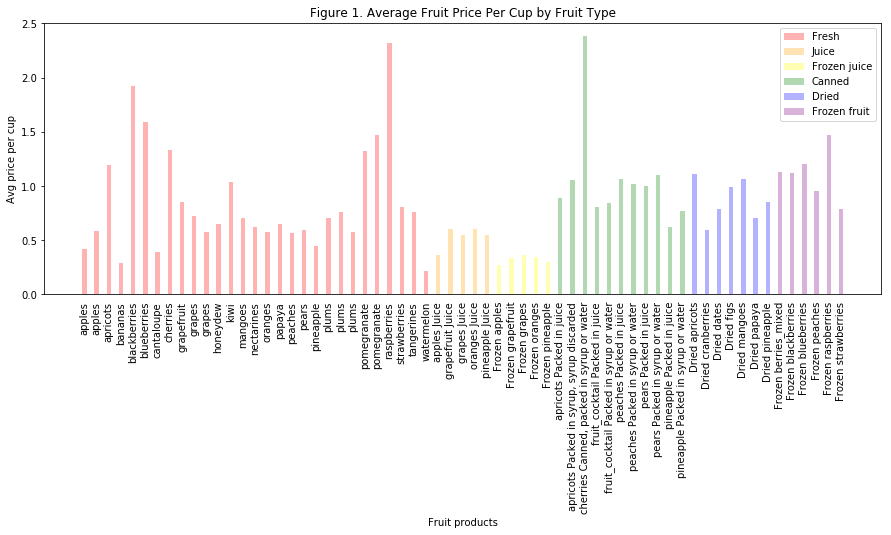

In [7]:
xvals = np.arange(len(all_data))
width = 0.35 

fresh = all_data[all_data.Type == "Fresh"]
juice = all_data[all_data.Type == "Juice"]
frozenJuice = all_data[all_data.Type == "Frozen juice"]
canned = all_data[all_data.Type == "Canned"]
dried = all_data[all_data.Type == "Dried"]
frozenFruit = all_data[all_data.Type == "Frozen fruit"]

l = [len(fresh), len(juice), len(frozenJuice), len(canned), len(dried), len(frozenFruit)]
l = np.array(l)

fig= plt.figure(figsize=(15,5),facecolor='w') 
ax = fig.add_subplot(111)
plt.setp(ax, xticks = xvals)
pA = plt.bar(np.arange(l[0]), fresh['Avg price per cup'], width, color= 'r', alpha= 0.3, label = "Fresh")
pB = plt.bar(np.arange(l[0], l[0:2].sum()), juice['Avg price per cup'], width, color= 'orange', alpha= 0.3, label = "Juice")
pC = plt.bar(np.arange(l[0:2].sum(), l[0:3].sum()), frozenJuice['Avg price per cup'], width, color= 'yellow', alpha= 0.3, label = "Frozen juice")
pD = plt.bar(np.arange(l[0:3].sum(), l[0:4].sum()), canned['Avg price per cup'], width, color= 'g', alpha= 0.3, label = "Canned")
pE = plt.bar(np.arange(l[0:4].sum(), l[0:5].sum()), dried['Avg price per cup'], width, color= 'blue', alpha= 0.3, label = "Dried")
pF = plt.bar(np.arange(l[0:5].sum(), l[0:6].sum()), frozenFruit['Avg price per cup'], width, color= 'purple', alpha= 0.3, label = "Frozen fruit")

plt.legend()
plt.ylabel('Avg price per cup')
plt.xlabel('Fruit products')
plt.title('Figure 1. Average Fruit Price Per Cup by Fruit Type')

# Remove ticks
plt.tick_params(
    axis='both',        # changes apply to the x-axis
    which='major',       # both major and minor ticks are affected
    bottom='off',       # ticks along the bottom edge are off
    top='off',          # ticks along the top edge are off
    right = 'off',
    left = 'on', 
    labelleft='on',
    labelbottom='on')

# create x labels
freshLabel = fresh.Fruit
juiceLabel = juice.Fruit + ' Juice'
frozenJuiceLabel = frozenJuice.Form + ' ' + frozenJuice.Fruit
cannedLabel = canned.Fruit + ' ' + canned.Form
driedLabel = dried.Form + ' ' + dried.Fruit
frozenFruitLabel = frozenFruit.Form + ' ' + frozenFruit.Fruit

allLabel = freshLabel.append(juiceLabel)
allLabel = allLabel.append(frozenJuiceLabel)
allLabel = allLabel.append(cannedLabel)
allLabel = allLabel.append(driedLabel)
allLabel = allLabel.append(frozenFruitLabel)
all_data['Label'] = allLabel.map(str.lower)

# create color array
all_data['Color']= 'red'
all_data['Color'][(all_data.Type == 'Juice')] = 'orange'
all_data['Color'][(all_data.Type == 'Frozen juice')] = 'yellow'
all_data['Color'][(all_data.Type == 'Canned')] = 'green'
all_data['Color'][(all_data.Type == 'Dried')] = 'blue'
all_data['Color'][(all_data.Type == 'Frozen fruit')] = 'purple'

ax.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(xvals, allLabel)

# rotate x labels by 90 degree
x=plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    
plt.show()

#### It's harder to see the x labels in a 90 degree angle, so we will make a horizontal bar chart instead. 

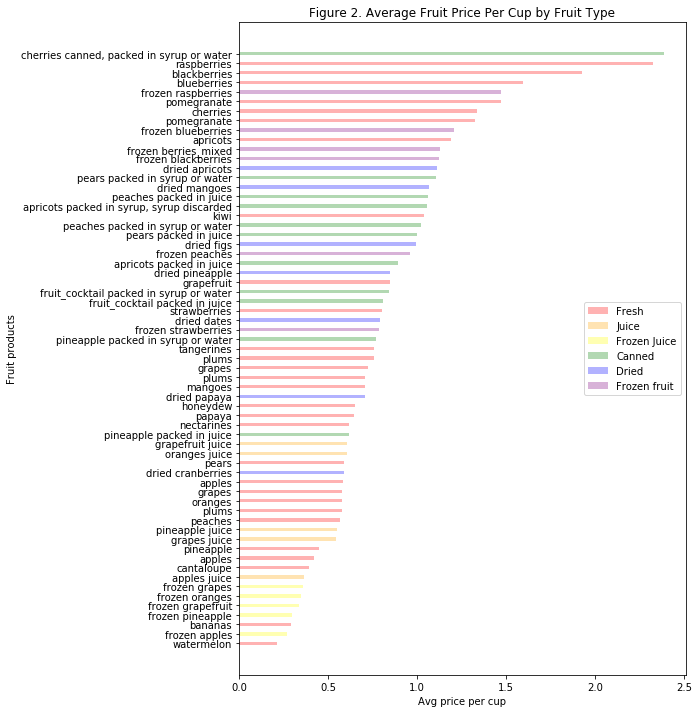

In [8]:
# create a sorted dataset
result = None
result = all_data.sort_values(['Avg price per cup'], ascending = 'True')

plt.figure(figsize=(8,12),facecolor='w') 
ax = fig.add_subplot(111)
plt.setp(ax, xticks = xvals)
j= plt.barh(np.arange(len(result)), result['Avg price per cup'], width, color=result.Color, alpha= 0.3)

plt.yticks(xvals, result.Label.map(str.lower))
plt.legend([pA, pB, pC, pD, pE, pF], ['Fresh', 'Juice', 'Frozen Juice', 'Canned', 'Dried', 'Frozen fruit'], loc = 5)
plt.xlabel('Avg price per cup')
plt.ylabel('Fruit products')
plt.title('Figure 2. Average Fruit Price Per Cup by Fruit Type')
plt.show()

#### With the plot above, it's now much easier to see that mnost of the frozen fruits have higher price, and most of the juice have lower price. In addition, frozen juice tend to have the lowest average price among all types, while canned and dried food tend to have a more average price. Unlike the others, fresh fruit average price spread evenly across the dataset. 

#### From the plot, we can see that the variance of fresh fruit is much larger than the other types. Let's make sure statistically. 

In [9]:
print('Standard Deviation of fresh fruit is ', round(fresh['Avg price per cup'].std(),3))
print('Standard Deviation of juice is ', round(juice['Avg price per cup'].std(),3))
print('Standard Deviation of frozen juice fruit is ', round(frozenJuice['Avg price per cup'].std(),3))
print('Standard Deviation of canned fruit is ', round(canned['Avg price per cup'].std(),3))
print('Standard Deviation of dried fruit is ', round(dried['Avg price per cup'].std(),3))
print('Standard Deviation of frozen fruit is ', round(frozenFruit['Avg price per cup'].std(),3))

Standard Deviation of fresh fruit is  0.493
Standard Deviation of juice is  0.099
Standard Deviation of frozen juice fruit is  0.038
Standard Deviation of canned fruit is  0.468
Standard Deviation of dried fruit is  0.192
Standard Deviation of frozen fruit is  0.232


#### It's shown above that the standard deviation of fresh fruit is indeed much larger than other types. However, the standard deviation of canned fruit is much larger than the rest as well since canned cherries is the most expensive product in the dataset, which increased the standard deviation of canned fruit. 

#### Now let's determine what fruit has the most investiment value. The fruit should have the highest average of average price per cup among all fruits and have the highest average prepration yield factor.  

In [10]:
# change variable type to float for the next calculation
all_data['Avg price per cup']= all_data['Avg price per cup'].astype(float)
all_data['Preparation yield factor']= all_data['Preparation yield factor'].astype(float)

avgData = all_data.groupby(['Fruit'], sort=True)['Avg price per cup', 'Preparation yield factor'].mean()
avgData.columns = ['Avg of APC', 'Avg PYF']

# select a subset of data with high values for both variables
print(avgData[(avgData['Avg of APC'] > 0.9) & (avgData['Avg PYF'] > 0.95)])

               Avg of APC  Avg PYF
Fruit                             
berries_mixed        1.13     1.00
blackberries         1.52     0.98
blueberries          1.40     0.97
figs                 0.99     0.96
raspberries          1.90     0.98


#### Based on the results, raspberries is the best for investiment value since it has the highest average of average price per cup, and its average preparation yielf factor is only lower than that of mixed berries. However, mixed berries contains many types of berries and it includes raspberries as well, so we don't consider it here. Therefore, raspberries is the best in terms of both criteria for investment value. 

In [11]:
maxProducts = all_data.groupby(['Fruit'], sort=True)['Avg price per cup'].max()
minProducts = all_data.groupby(['Fruit'], sort=True)['Avg price per cup'].min()
difference = pd.DataFrame(maxProducts - minProducts)

# remove the ones with one product
difference = difference[difference['Avg price per cup'] != 0]
difference = difference.reset_index()
difference = difference.sort_values(by= 'Avg price per cup', ascending = False)
difference

,Fruit,Avg price per cup
4,cherries,1.05
16,raspberries,0.85
2,blackberries,0.80
13,pineapple,0.55
12,pears,0.52
6,grapefruit,0.51
11,peaches,0.49
3,blueberries,0.39
7,grapes,0.36
8,mangoes,0.36


#### Based on the Table, we can see that strawberries have the least difference in average price per cup between different type of products. Frozen and fresh strawberries cost around the same. On the other hand, the berry type of fruits, namely, cherries, raspberries, and blackberries, have a noticeable difference between product types. For example, canned cherries cost almost twice as much as fresh cherries for some reason. 

## Machine Learning algorithms

In [12]:
# import necessary packages 
import pydotplus
import pydot
import graphviz

from sklearn import svm
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import Image  

C:\Users\huiyu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Train-Validation Split

Some methods such as SVM and kmeans requires numerical variables for analysis, so we'll convert some variables for those methods. 

In [13]:
# convert fruit to float for k means
for i in range(len(all_data.Fruit.unique())): 
    f = all_data.Fruit.unique()[i]
    all_data.ix[(all_data.Fruit == f), 'Fruit.float'] = float(i)

for j in range(len(all_data.Type.unique())): 
    f = all_data.Type.unique()[j]
    all_data.ix[(all_data.Type == f), 'Type.float'] = float(j)

for k in range(len(all_data.Form.unique())): 
    f = all_data.Form.unique()[k]
    all_data.ix[(all_data.Form == f), 'Form.float'] = float(k)

# ensure no sparse cell
all_data['Price group'] = pd.cut(all_data['Avg price per cup'], 4)



We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use seed=2 so that everyone gets the same split. 

In [14]:
useful_columns = all_data[[ 'Fruit.float', 'Preparation yield factor', 'Size of a cup equivalent', 'Form.float', 'Type.float']]
X_train, X_test, y_train, y_test = train_test_split(useful_columns, all_data['Price group'], test_size=0.2, random_state=0)

print('Training set   : %d data points' % len(X_train))
print('Validation set : %d data points' % len(X_test))

Training set   : 50 data points
Validation set : 13 data points


### Multinomial Regression

Since there are more than 2 price groups, we can use an extension of logistic regression, multinomial regression, to predict the price group. 

In [15]:
# split data
useful_columns = all_data[[ 'Fruit.float', 'Preparation yield factor', 'Size of a cup equivalent', 'Form.float', 'Type.float']]
X_train, X_test, y_train, y_test = train_test_split(useful_columns, all_data['Price group'], test_size=0.2, random_state=0)

# fit a Multinomial regression model to the data
model = LogisticRegression()
model.fit(X_train, y_train)

# make predictions
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(y_test, predicted))
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
print(confusion_matrix)
print('Accuracy: ', round((confusion_matrix[0][0]+confusion_matrix[1][1])/confusion_matrix.sum(),2))

                precision    recall  f1-score   support

 (0.21, 0.756]       0.88      0.88      0.88         8
(0.756, 1.299]       0.80      0.80      0.80         5

   avg / total       0.85      0.85      0.85        13

[[7 1]
 [1 4]]
Accuracy:  0.85


### Support Vector Machine (SVM)
Let us estimate the accuracy of a linear kernel support vector machine (SVM) on our dataset by splitting the data, fitting a model and computing the score 10 consecutive times with different splits. 

In [16]:
# split data
useful_columns = all_data[[ 'Fruit.float', 'Preparation yield factor', 'Size of a cup equivalent', 'Form.float', 'Type.float']]
X_train, X_test, y_train, y_test = train_test_split(useful_columns, all_data['Price group'], test_size=0.2, random_state=0)

# fit a Multinomial regression model to the data
model = SVC()
model.fit(X_train, y_train)

# make predictions
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(y_test, predicted))
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
print(confusion_matrix)
print('Accuracy: ', round((confusion_matrix[0][0]+confusion_matrix[1][1])/confusion_matrix.sum(),2))

                precision    recall  f1-score   support

 (0.21, 0.756]       0.70      0.88      0.78         8
(0.756, 1.299]       0.67      0.40      0.50         5

   avg / total       0.69      0.69      0.67        13

[[7 1]
 [3 2]]
Accuracy:  0.69


### Naive Bayes

Naive Bayes is a classification technique based on Bayes Theorem with an assumption of independence among predictors to model the conditional relationship of each attribute to the class variable. 


In [17]:
# split data
useful_columns = all_data[[ 'Fruit.float', 'Preparation yield factor', 'Size of a cup equivalent', 'Form.float', 'Type.float']]
X_train, X_test, y_train, y_test = train_test_split(useful_columns, all_data['Price group'], test_size=0.2, random_state=0)

# fit a k-nearest neighbor model to the data
model = GaussianNB()
model.fit(X_train, y_train)

# make predictions
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(y_test, predicted))
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
print(confusion_matrix)
print('Accuracy: ', round((confusion_matrix[0][0]+confusion_matrix[1][1] + confusion_matrix[2][2])/confusion_matrix.sum(),2))

                precision    recall  f1-score   support

 (0.21, 0.756]       1.00      0.25      0.40         8
(0.756, 1.299]       0.67      0.80      0.73         5
(1.843, 2.387]       0.00      0.00      0.00         0

   avg / total       0.87      0.46      0.53        13

[[2 2 4]
 [0 4 1]
 [0 0 0]]
Accuracy:  0.46


C:\Users\huiyu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### k-Nearest Neighbor 

The k-nearest neighbors algorithm (k-NN) is a non-parametric method for classification and regression. By using a similarity function, we can locate similar data into groups. By doing so, we can make prediction of our test set by training a model on our training set and check the model fit and accuracy of the predictions.

In [18]:
# split data
useful_columns = all_data[[ 'Fruit.float', 'Preparation yield factor', 'Size of a cup equivalent', 'Form.float', 'Type.float']]
X_train, X_test, y_train, y_test = train_test_split(useful_columns, all_data['Price group'], test_size=0.2, random_state=0)

# fit a k-nearest neighbor model to the data
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# make predictions
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(y_test, predicted))
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
print(confusion_matrix)
print('Accuracy: ', round((confusion_matrix[0][0]+confusion_matrix[1][1])/confusion_matrix.sum(),2))

                precision    recall  f1-score   support

 (0.21, 0.756]       0.86      0.75      0.80         8
(0.756, 1.299]       0.67      0.80      0.73         5

   avg / total       0.78      0.77      0.77        13

[[6 2]
 [1 4]]
Accuracy:  0.77


### Decision Tree

#### Decision Tree Classifier with criterion gini index

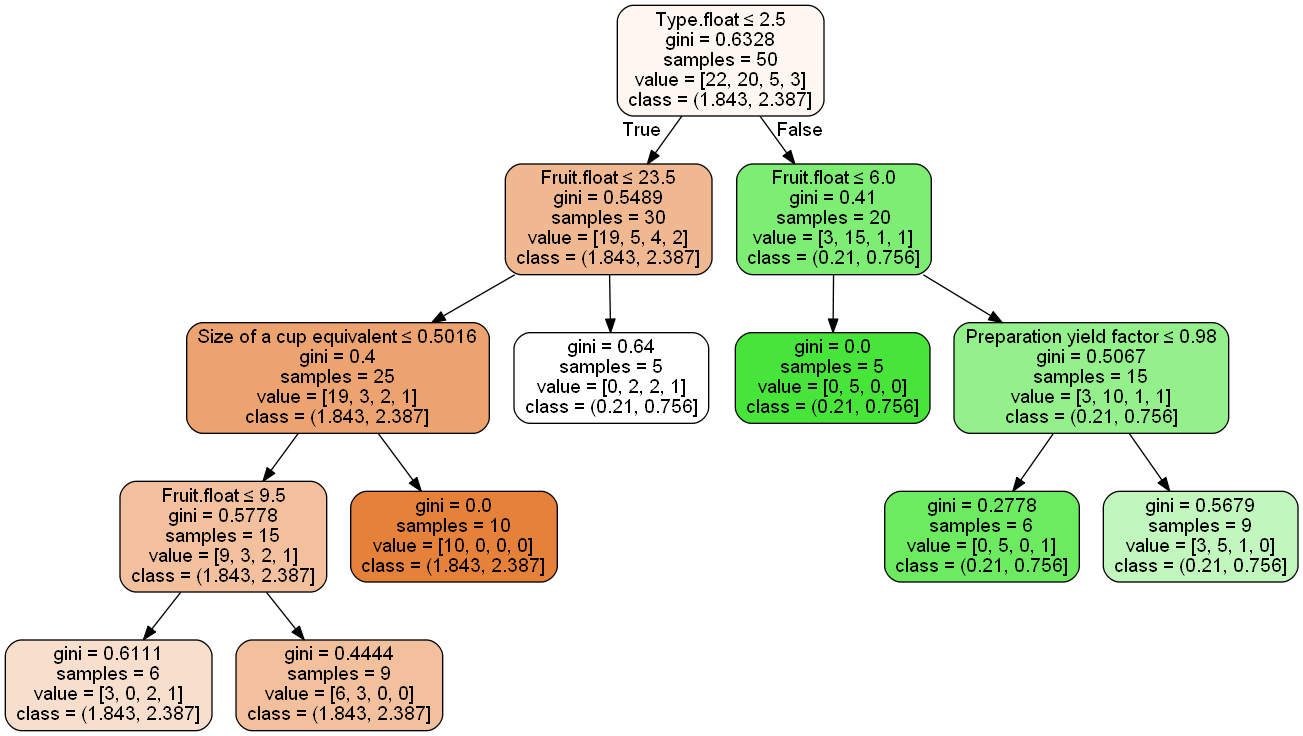

In [19]:
features = all_data[[ 'Fruit.float', 'Preparation yield factor', 'Size of a cup equivalent', 'Form.float', 'Type.float']]
X_train, X_test, y_train, y_test = train_test_split(features, all_data['Price group'], test_size=0.2, random_state=0)

clf_gini = tree.DecisionTreeClassifier(criterion = "gini", random_state = 0, min_samples_leaf=5)
clf_gini = clf_gini.fit(X_train, y_train)

from IPython.display import Image  
dot_data = tree.export_graphviz(clf_gini, out_file=None, 
                         feature_names=features.columns,  
                         class_names=y_train.unique(),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

#### Decision Tree Classifier with criterion information gain (entropy)

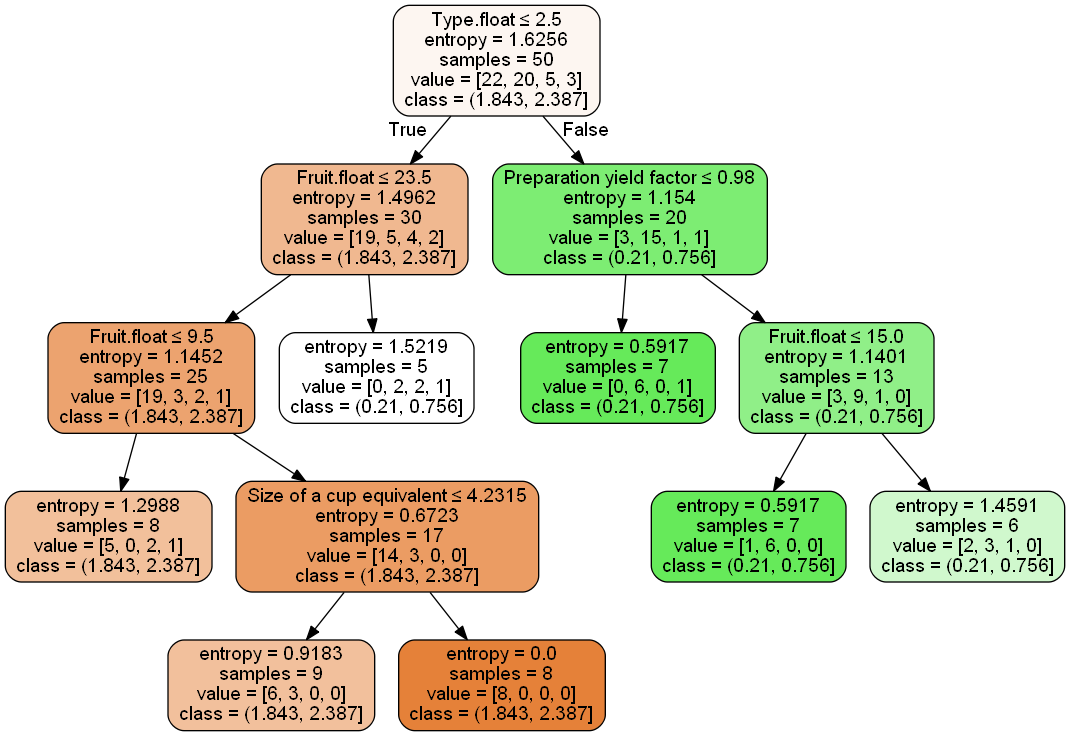

In [20]:
clf_entropy = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 0, min_samples_leaf=5)
clf_entropy = clf_entropy.fit(X_train, y_train)

from IPython.display import Image  
dot_data = tree.export_graphviz(clf_entropy, out_file=None, 
                         feature_names=features.columns,  
                         class_names=y_train.unique(),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

#### Prediction with these two decision trees 

In [21]:
y_pred = clf_gini.predict(X_test)
print('Accuracy on the test set is: ', round(sum(y_pred == y_test)/len(y_test),2))

Accuracy on the test set is:  0.85


In [22]:
y_pred = clf_entropy.predict(X_test)
print('Accuracy on the test set is: ', round(sum(y_pred == y_test)/len(y_test),2))

Accuracy on the test set is:  0.85


Let's perform feature selection based on these two models. 

In [23]:
features =  all_data[['Type.float']]
X_train, X_test, y_train, y_test = train_test_split(features, all_data['Price group'], test_size=0.2, random_state=0)

clf_gini = tree.DecisionTreeClassifier(criterion = "gini", random_state = 0, min_samples_leaf=5)
clf_gini = clf_gini.fit(X_train, y_train)
y_pred = clf_gini.predict(X_test)
print('Accuracy (Gini): ', round(sum(y_pred == y_test)/len(y_test),2))

clf_entropy = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 0, min_samples_leaf=5)
clf_entropy = clf_entropy.fit(X_train, y_train)
y_pred = clf_entropy.predict(X_test)
print('Accuracy (Entropy): ', round(sum(y_pred == y_test)/len(y_test),2))

Accuracy (Gini):  0.92
Accuracy (Entropy):  0.92


Interestingly, the most important feature for price prediction is fruit type (frozen fruit, juice, etc). Let's visualize the decision trees based on fruit type.  

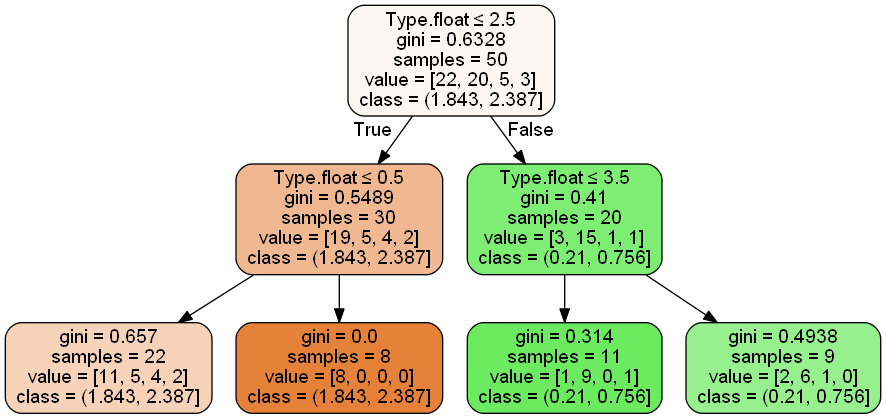

In [24]:
from IPython.display import Image  
dot_data = tree.export_graphviz(clf_gini, out_file=None, 
                         feature_names=features.columns,  
                         class_names=y_train.unique(),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

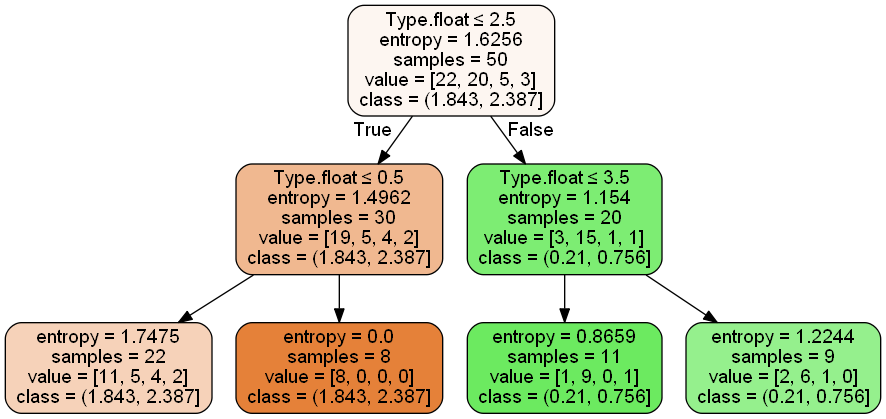

In [25]:
from IPython.display import Image  
dot_data = tree.export_graphviz(clf_entropy, out_file=None, 
                         feature_names=features.columns,  
                         class_names=y_train.unique(),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

Based on The decision trees above, we can see that if Type <= 0.5, then class is (1.843, 2.387), else if Type is >= 2.5, then the class is (0.21, 0.756]. The middle two classes seem to be missing. This is mostly due to the sparcity of certain price groups and how data was distributed between training and testing sets. If there aren't enough data in the training set for a price group, then the prediction may not be accurate. In the current data, the two highest price groups, (1.299, 1.843] and (1.843, 2.387], only have 5 and 3 data points, respectively. It's likely that the last group have data in the training set, but not the other two groups. However, the price group (0.756, 1.299] have 25 data points, so the inability to predict that price group seems strange. 

We will try to have more data points in each price groups, then perform the modeling and prediction once again. Since the result of using either Gini index or entropy are similar, we will just use Gini index below. 

#### Decision trees without sparce groups for dependent variable

In [26]:
# ensure no sparse cell
k= np.array([0,0.5, 0.7, 1,2.9])
all_data['Price group'] = pd.cut(all_data['Avg price per cup'], k)
all_data.groupby(['Price group']).count()

,Fruit,Type,Form,Price,Unit,Preparation yield factor,Size of a cup equivalent,Unit2,Avg price per cup,Label,Color,Fruit.float,Type.float,Form.float
Price group,,,,,,,,,,,,,,
"(0, 0.5]",11,11,11,11,11,11,11,11,11,11,11,11,11,11
"(0.5, 0.7]",15,15,15,15,15,15,15,15,15,15,15,15,15,15
"(0.7, 1]",18,18,18,18,18,18,18,18,18,18,18,18,18,18
"(1, 2.9]",19,19,19,19,19,19,19,19,19,19,19,19,19,19


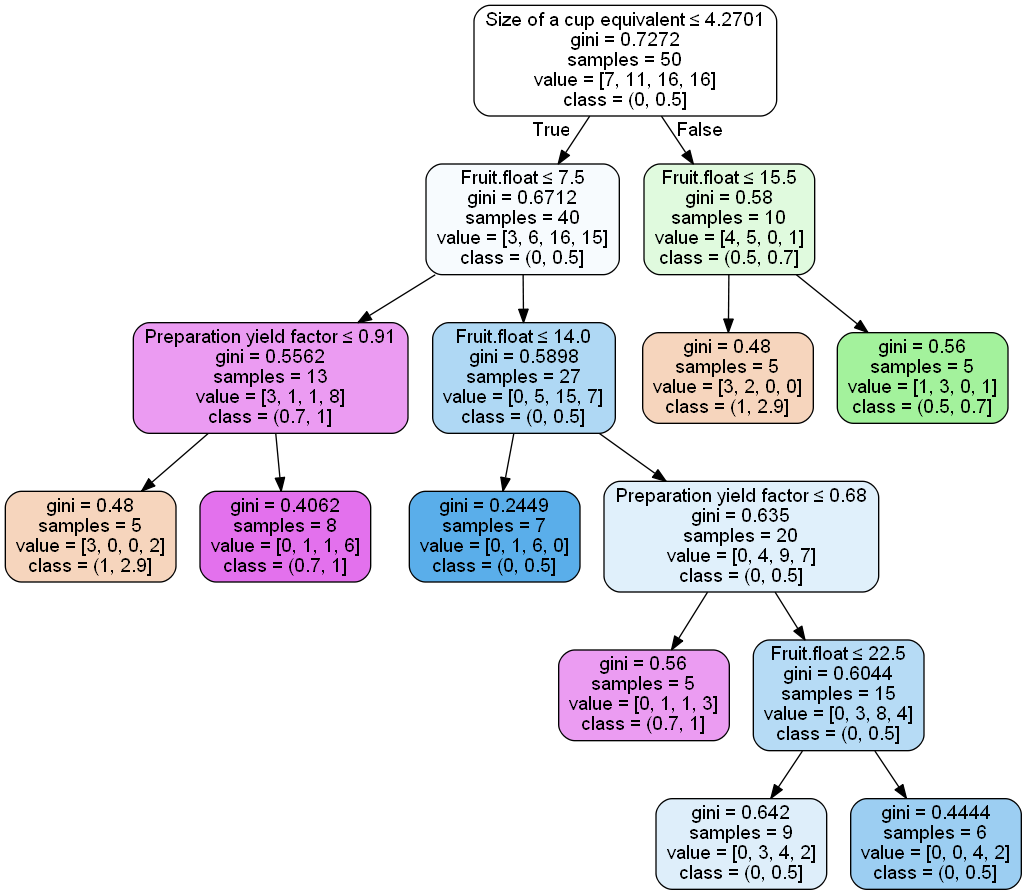

In [27]:
features = all_data[[ 'Fruit.float', 'Preparation yield factor', 'Size of a cup equivalent', 'Form.float', 'Type.float']]
X_train, X_test, y_train, y_test = train_test_split(features, all_data['Price group'], test_size=0.2, random_state=0)

clf_gini = tree.DecisionTreeClassifier(criterion = "gini", random_state = 0, min_samples_leaf=5)
clf_gini = clf_gini.fit(X_train, y_train)

from IPython.display import Image  
dot_data = tree.export_graphviz(clf_gini, out_file=None, 
                         feature_names=features.columns,  
                         class_names=y_train.unique(),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

In [28]:
y_pred = clf_gini.predict(X_test)
print('Accuracy on the test set is: ', round(sum(y_pred == y_test)/len(y_test),2))

Accuracy on the test set is:  0.38


Even though all price groups appear on the decision tree, the precision power is quite low. It's possible that decision tree have a better accuracy when the sizes of price groups are approximately the same. Either way, we have to watch out for this strange behavior of decision trees. 

### Conclusion

From the exploratory analysis, we can see the distribution of price for each different category (Figure 1 and 2). Majority of the fruit category have price across the spectrum (such as fresh and canned), but some have a much smaller standard deviation (such as juice and frozen juice). it's now much easier to see that mnost of the frozen fruits have higher price, and most of the juice have lower price. 

When we applied the machine learning algorithms, multinomial regression and decision tree seems to have the highest accuracy of 0.85. K-nearest neighbor and SVM performed similarly with an accuracy of 0.77 and 0.69, respectively. On the other hand, the performance of Naive Bayes is poor (accuracy of 0.46). It's likely that the assumption of Naive Bayes weren't met. Also keep in mind the decision tree with high accuracy could only predict certain price groups. 